In [1]:
data_file = "../Simulations/toy_data_01.nc"

In [2]:
import hextraj

import xarray as xr
from matplotlib import pyplot as plt
import cartopy

## Load data and check raw data

In [3]:
ds_traj = xr.open_dataset(data_file)
ds_traj

<xarray.Dataset>
Dimensions:     (traj: 144, obs: 121)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
    U           (traj, obs) float32 ...
    V           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1.dev20+g92f2fb90
    parcels_mesh:           spherical

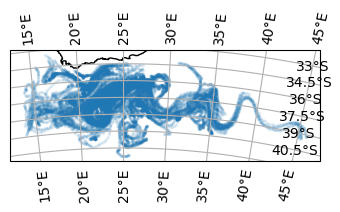

In [5]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Stereographic(
        central_latitude=ds_traj.lat.mean().data[()],
        central_longitude=ds_traj.lon.mean().data[()]
    )},
    figsize=(4, 4),
)
ds_traj.to_dataframe().plot.scatter(x="lon", y="lat", s=2, alpha=0.1, ax=ax, transform=cartopy.crs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True);

## Create hex labeller

This uses a [Lamber azimuthal equal-area projection](https://en.wikipedia.org/wiki/Lambert_azimuthal_equal-area_projection) which assures equal area of all hexagons and preserves angles between all vectors pointing away from the center of the projection.

We center the projection about the middle point of all trajectories.

In [6]:
lon_origin = ((ds_traj.lon.max() + ds_traj.lon.min()) / 2.0).data[()]
lat_origin = ((ds_traj.lat.max() + ds_traj.lat.min()) / 2.0).data[()]
hex_size_meters = 200_000 

In [7]:
hex_proj = hextraj.HexProj(
    lon_origin=lon_origin,
    lat_origin=lat_origin,
    hex_size_meters=hex_size_meters,
)

hex_proj

/srv/conda/envs/notebook/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


HexProj(projection_name='laea', lon_origin=29.791340827941895, lat_origin=-38.089969635009766, hex_size_meters=200000, hex_orientation='flat', )

## Compute labels

Labels are three element tuples.

In [8]:
ds_traj["hex_labels"] = xr.apply_ufunc(
    hex_proj.lon_lat_to_hex_AoS,
    ds_traj.lon, 
    ds_traj.lat,
)

display(ds_traj)

<xarray.Dataset>
Dimensions:     (traj: 144, obs: 121)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 0.0 0.0 0.0 0.0 ... 143.0 143.0 143.0 143.0
    time        (traj, obs) datetime64[ns] 2021-01-01T00:30:00 ... 2021-01-31...
    lat         (traj, obs) float32 -39.17 -39.02 -38.9 ... -39.19 -39.21 -39.25
    lon         (traj, obs) float32 22.5 22.55 22.61 22.66 ... 17.16 17.18 17.17
    z           (traj, obs) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    U           (traj, obs) float32 nan 2.598e-06 ... 1.845e-07 -7.776e-07
    V           (traj, obs) float32 nan 5.796e-06 ... -1.211e-06 -2.669e-06
    hex_labels  (traj, obs) object (-2, 1, 1) (-2, 1, 1) ... (-4, 1, 3)
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1.dev20+g92f2fb90
    parcels_mesh:           spherical

### Aggregate data into hexagons

Create empty dataset:

In [9]:
data_agg_hex = xr.Dataset()
data_agg_hex

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

Aggregate particle position count:

In [10]:
data_agg_hex["particle_obs_count"] = (
    ds_traj.lon
    .groupby(ds_traj["hex_labels"]).count()
)
data_agg_hex["particle_obs_count"].attrs["long_name"] = "number of positions recorded"
data_agg_hex["particle_obs_count"].attrs["units"] = None

Aggregate U, V and squared velocities:

In [11]:
data_agg_hex["U"] = (
    ds_traj.U
    .groupby(ds_traj["hex_labels"]).mean()
)

data_agg_hex["U2"] = (
    (ds_traj.U ** 2)
    .groupby(ds_traj["hex_labels"]).mean()
)

data_agg_hex["V"] = (
    ds_traj.V
    .groupby(ds_traj["hex_labels"]).mean()
)

data_agg_hex["V2"] = (
    (ds_traj.V ** 2)
    .groupby(ds_traj["hex_labels"]).mean()
)

Add positions of the hex labels:

In [12]:
_lon, _lat = hex_proj.hex_to_lon_lat_SoA(hextraj.aux.hex_AoS_to_SoA(data_agg_hex["hex_labels"].data))

data_agg_hex = data_agg_hex.assign_coords(lon=("hex_labels", _lon))
data_agg_hex = data_agg_hex.assign_coords(lat=("hex_labels", _lat))

In [13]:
data_agg_hex

<xarray.Dataset>
Dimensions:             (hex_labels: 28)
Coordinates:
  * hex_labels          (hex_labels) object (-5, 2, 3) ... (5, -3, -2)
    lon                 (hex_labels) float64 12.48 13.18 15.59 ... 43.39 47.1
    lat                 (hex_labels) float64 -38.38 -35.34 ... -37.3 -38.38
Data variables:
    particle_obs_count  (hex_labels) int64 82 27 206 635 311 ... 67 69 26 61 36
    U                   (hex_labels) float32 -1.309e-06 -1.814e-06 ... 2.058e-06
    U2                  (hex_labels) float32 6.788e-12 8.051e-12 ... 7.148e-12
    V                   (hex_labels) float32 -6.445e-06 -5.26e-07 ... -3.678e-06
    V2                  (hex_labels) float32 5.543e-11 1.045e-11 ... 1.404e-11

### Visualize aggregated data

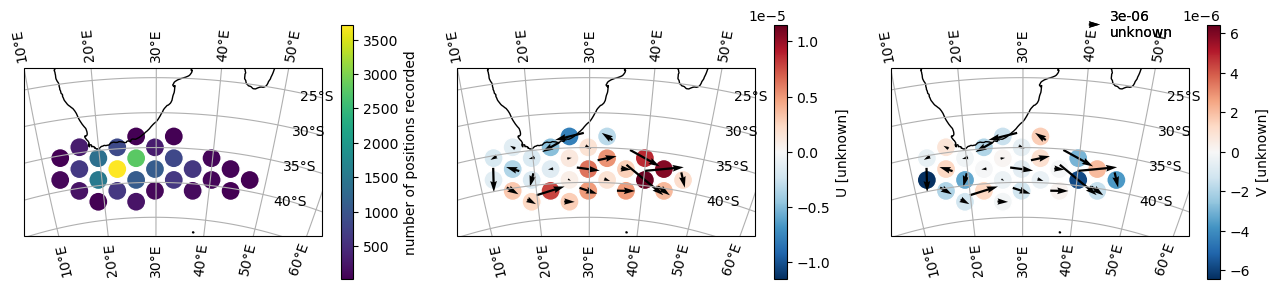

In [14]:
fig, ax = plt.subplots(
    1, 3,
    subplot_kw={"projection": cartopy.crs.Stereographic(
        central_latitude=lat_origin,
        central_longitude=lon_origin,
    )},
    figsize=(13, 3),
)

data_agg_hex.plot.scatter(
    x="lon", y="lat", hue="particle_obs_count", s=190,      
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

data_agg_hex.plot.scatter(
    x="lon", y="lat", hue="U", s=190,      
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)
data_agg_hex.plot.quiver(
    u="U", v="V", x="lon", y="lat",
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

data_agg_hex.plot.scatter(
    x="lon", y="lat", hue="V", s=190,      
    ax=ax[2], transform=cartopy.crs.PlateCarree(),
)
data_agg_hex.plot.quiver(
    u="U", v="V", x="lon", y="lat",
    ax=ax[2], transform=cartopy.crs.PlateCarree(),
)


for _ax in ax.flat:
    _ax.coastlines()
    _ax.gridlines(draw_labels=True)
    _ax.set_extent([10, 55, -45, -22])
    
fig.tight_layout()

### Connectivity

In [15]:
connection_count = (
    xr.merge(
        (
            ds_traj.isel(obs=0).hex_labels.rename("hex_start"),
            ds_traj.isel(obs=-1).hex_labels.rename("hex_end"),
        )
    )
    .to_dataframe().reset_index()
    .groupby(["hex_start", "hex_end"])["traj"].count()
    .rename("connection_count")
    .to_frame()
)

display(connection_count)

connection_count
hex_start   hex_end                      
(-2, 1, 1)  (-5, 3, 2)                  2
            (-4, 1, 3)                  4
            (-2, 0, 2)                  2
            (-2, 1, 1)                 14
            (-1, -1, 2)                 3
            (-1, 0, 1)                  1
            (-1, 1, 0)                  5
            (0, 0, 0)                   1
            (1, -1, 0)                  1
            (1, 0, -1)                  2
            (1, 1, -2)                  1
            (2, -2, 0)                  1
            (2, -1, -1)                 3
            (3, -1, -2)                 1
(-2, 2, 0)  (-4, 1, 3)                  4
            (-4, 2, 2)                  1
            (-4, 3, 1)                  9
            (-3, 1, 2)                  2
            (-3, 2, 1)                  5
            (-2, 0, 2)                  2
            (-2, 1, 1)                  4
            (-1, -1, 2)                 1
            (-1, 0, 1)                  2
            (0, -1, 1)                  1
(-1, 0, 1)  (-1, 1, 0)                  1
            (0, -1, 1)                  2
            (0, 0, 0)                   1
            (1, -1, 0)                  4
            (1, 0, -1)                  3
            (2, -2, 0)                  2
            (2, -1, -1)                 2
            (3, -1, -2)                 3
            (4, -2, -2)                 1
(-1, 1, 0)  (-4, 1, 3)                  1
            (-3, 1, 2)                  2
            (-3, 2, 1)                  2
            (-2, 0, 2)                  2
            (-2, 1, 1)                 13
            (-2, 2, 0)                  1
            (-1, 0, 1)                  1
            (-1, 1, 0)                  1
            (0, 0, 0)                   8
            (0, 1, -1)                  2
            (1, -1, 0)                  1
            (1, 0, -1)                  1
            (2, -2, 0)                  2
            (2, -1, -1)                 5
            (3, -2, -1)                 1
            (4, -3, -1)                 3
            (5, -3, -2)                 2
(-1, 2, -1) (-5, 2, 3)                  1
            (-4, 1, 3)                  1
            (-4, 3, 1)                  2
            (-3, 2, 1)                  1

In [16]:
import seaborn as sns

<AxesSubplot: xlabel='None-hex_end', ylabel='hex_start'>

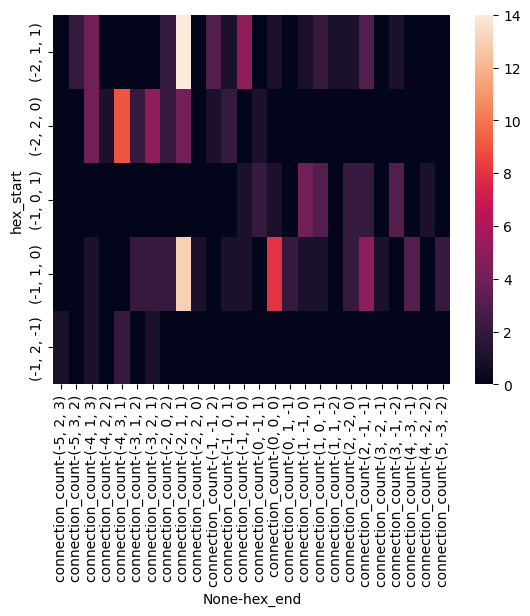

In [17]:
sns.heatmap(connection_count.unstack(level=-1).fillna(0))